# Tutorial: k-Nearest Neighbors (KNN)

En este cuaderno veremos KNN paso a paso. La idea central: para clasificar algo nuevo, miramos a qué se parece más dentro de los ejemplos que ya conocemos.

Qué haremos:
- Cargar el dataset Wine (vinos con 13 características y 3 clases).
- Explorar un poco los datos.
- Preparar los datos (dividir y escalar).
- Entrenar KNN y medir qué tan bien funciona.
- Probar distintos valores de k y de la métrica de distancia.
- Visualizar en 2D con PCA para entender mejor el modelo.


In [1]:
# Usaremos el dataset Wine durante todo el tutorial.
from sklearn import datasets
import pandas as pd
import numpy as np

# Cargar únicamente el dataset Wine (simplificado)
dataset_name = "wine"
wine = datasets.load_wine()

# Extraer estructuras necesarias
X = wine.data
y = wine.target
feature_names = list(wine.feature_names)
target_names = wine.target_names

# DataFrame para exploración
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

print(f"Dataset: {dataset_name} -> X: {X.shape}, y: {y.shape}, clases: {len(np.unique(y))}")
print("Features:", feature_names[:5], ("..." if len(feature_names) > 5 else ""))

Dataset: wine -> X: (178, 13), y: (178,), clases: 3
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium'] ...


## ¿Por qué el escalado importa en KNN?

KNN usa distancias entre puntos. Si una variable tiene números mucho más grandes que otra, “pesa” más en la distancia y puede dominar la decisión. Por eso, antes de KNN solemos estandarizar (media 0, varianza 1).

- k pequeño: modelo muy sensible al ruido (puede sobreajustar).
- k grande: modelo más suave (puede subajustar).
- Distancia: p=2 (Euclídea) es la más común; p=1 (Manhattan) a veces es más robusta.
- Pesos: `uniform` (todos igual) vs `distance` (cercanos pesan más).

Ejemplo: pensemos en “vecinos en un mapa”. Si todas las calles están en la misma escala, medir distancias es justo; si una calle está en kilómetros y otra en metros, el cálculo se distorsiona.


## 1 Fundamentos

- Guardamos los ejemplos de entrenamiento (no aprendemos una fórmula complicada).
- Para un caso nuevo, buscamos sus k vecinos más cercanos en el entrenamiento.
- Hacemos una votación: la clase que más se repite entre esos k vecinos es la predicción.
- Podemos dar más peso a los vecinos más cercanos que a los lejanos.

Lo importante será escoger bien k y tener las variables en una escala comparable.


## ¿Qué es "k" exactamente?

k es el número de vecinos que tendremos en cuenta para decidir la clase de un nuevo ejemplo.

- k=1: miramos solo el vecino más cercano; muy sensible al ruido.
- k mediano (p.ej., 5–11): balance entre detalle y robustez.
- k grande: las decisiones se suavizan; podemos perder detalles finos.

Cómo elegirlo
- Validación (GridSearchCV) probando varios valores de k.
- En binario, valores impares evitan empates.
- Regla rápida orientativa (no estricta): k ≈ √N (si N es el tamaño del entrenamiento); luego ajustamos con validación.

Relación con sesgo y varianza
- k pequeño → baja sesgo, alta varianza (se ajusta mucho al detalle/ruido).
- k grande → alto sesgo, baja varianza (fronteras más suaves, menos sensibilidad al ruido).



### Mini ejemplo mental

Imaginemos puntos de tres clases (0, 1 y 2) en un plano. Tomamos un punto nuevo y preguntamos a sus vecinos:

- Con k=1, basta 1 vecino para decidir; si ese vecino es un “caso raro”, la decisión puede ser inestable.
- Con k=5, votan 5; si 3 de ellos son clase 1 y 2 son clase 2, predecimos clase 1.
- Con k=15, incorporamos vecinos más lejanos; puede que “aplastemos” detalles locales y la frontera se vuelva muy suave.

En la práctica, probamos varios k y nos quedamos con el que da mejor validación cruzada.


## 2 Parte matemática: distancias y voto

Para medir cercanía usamos una distancia. Dos opciones muy usadas:
- Euclídea (p=2): la “línea recta” clásica en varias dimensiones.
- Manhattan (p=1): suma de diferencias absolutas (como moverse por cuadras).

Con la distancia elegida, tomamos los k más cercanos y votamos la clase. Si te interesa la fórmula, aquí va la Euclídea entre dos vectores p y q:

$$d(p,q) = \sqrt{\sum_j (p_j - q_j)^2}$$

En las secciones de abajo probaremos p=1 y p=2 para ver cuál nos da mejor resultado.


## 3 Librerías y Herramientas Clave

Para construir nuestro modelo KNN, nos apoyaremos en varias librerías de Python que son el estándar en ciencia de datos. A continuación, describimos las que usaremos y su rol en nuestro proyecto:

### Librerías Principales

-   **NumPy**: Es la base para la computación numérica en Python. La usaremos para manejar los arrays de datos de manera eficiente.
-   **Pandas**: Nos permite organizar los datos en `DataFrames`, una estructura tabular muy cómoda para explorar, limpiar y analizar la información antes del modelado.
-   **Matplotlib** y **Seaborn**: Son nuestras herramientas para visualizar los datos. Con ellas crearemos gráficos como *pairplots* y matrices de confusión para entender mejor las relaciones en los datos y los resultados del modelo.

### Scikit-learn: Nuestro Kit de Machine Learning

Scikit-learn es la librería central para este tutorial. Nos provee todas las herramientas necesarias para el flujo de trabajo de machine learning:

-   `datasets.load_wine()`: Carga el conjunto de datos de vinos que usaremos como ejemplo.
-   `train_test_split()`: Una función crucial para dividir nuestros datos en un conjunto de **entrenamiento** (para que el modelo aprenda) y uno de **prueba** (para evaluar su rendimiento en datos no vistos).
-   `StandardScaler`: Se encarga de **estandarizar** las características. Este paso es fundamental en KNN para que todas las variables contribuyan por igual al cálculo de distancias.
-   `KNeighborsClassifier`: Es la implementación del **algoritmo KNN**. Aquí definiremos hiperparámetros clave como `n_neighbors` (el valor de k), `p` (la métrica de distancia) y `weights` (cómo se pondera el voto de los vecinos).
-   `metrics`: Un módulo que contiene funciones para evaluar el rendimiento del modelo, como `accuracy_score` (precisión global), `confusion_matrix` (matriz de confusión) y `classification_report` (reporte detallado por clase).

Nuestro flujo de trabajo seguirá estos pasos: dividir → escalar → entrenar → evaluar → ajustar hiperparámetros.

---

## 4 Pipeline de Implementación

Comenzamos importando todas las librerías necesarias.

In [2]:
%pip install numpy pandas matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importaciones generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones de Scikit-learn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

# Configuración para gráficos
sns.set(style="whitegrid")

### Carga de Datos

Cargaremos el dataset Wine y lo convertiremos a un DataFrame de Pandas para explorarlo.

In [4]:
# Usar el dataset Wine ya cargado arriba
print(f"Clases: {list(target_names)}")
print(f"Número de características: {len(feature_names)}")
print(f"Primeras columnas: {feature_names[:5]}{' ...' if len(feature_names) > 5 else ''}")

df.head()

Clases: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]
Número de características: 13
Primeras columnas: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium'] ...


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### 4.1 Preprocesamiento y Análisis Exploratorio

Primero, realizamos un análisis estadístico básico y visualizamos los datos.

In [5]:
# 1. Análisis estadístico (avg, std, min, max...)
print("--- Análisis Estadístico Básico (Wine) ---")
print(df[feature_names].describe().T)

print("\n--- Conteo de Clases ---")
class_names_series = pd.Series(y).map(dict(enumerate(target_names)))
print(class_names_series.value_counts())

--- Análisis Estadístico Básico (Wine) ---
                              count        mean         std     min       25%  \
alcohol                       178.0   13.000618    0.811827   11.03   12.3625   
malic_acid                    178.0    2.336348    1.117146    0.74    1.6025   
ash                           178.0    2.366517    0.274344    1.36    2.2100   
alcalinity_of_ash             178.0   19.494944    3.339564   10.60   17.2000   
magnesium                     178.0   99.741573   14.282484   70.00   88.0000   
total_phenols                 178.0    2.295112    0.625851    0.98    1.7425   
flavanoids                    178.0    2.029270    0.998859    0.34    1.2050   
nonflavanoid_phenols          178.0    0.361854    0.124453    0.13    0.2700   
proanthocyanins               178.0    1.590899    0.572359    0.41    1.2500   
color_intensity               178.0    5.058090    2.318286    1.28    3.2200   
hue                           178.0    0.957449    0.228572    0.4


--- Gráfico de Dispersión (Pairplot) - Wine ---


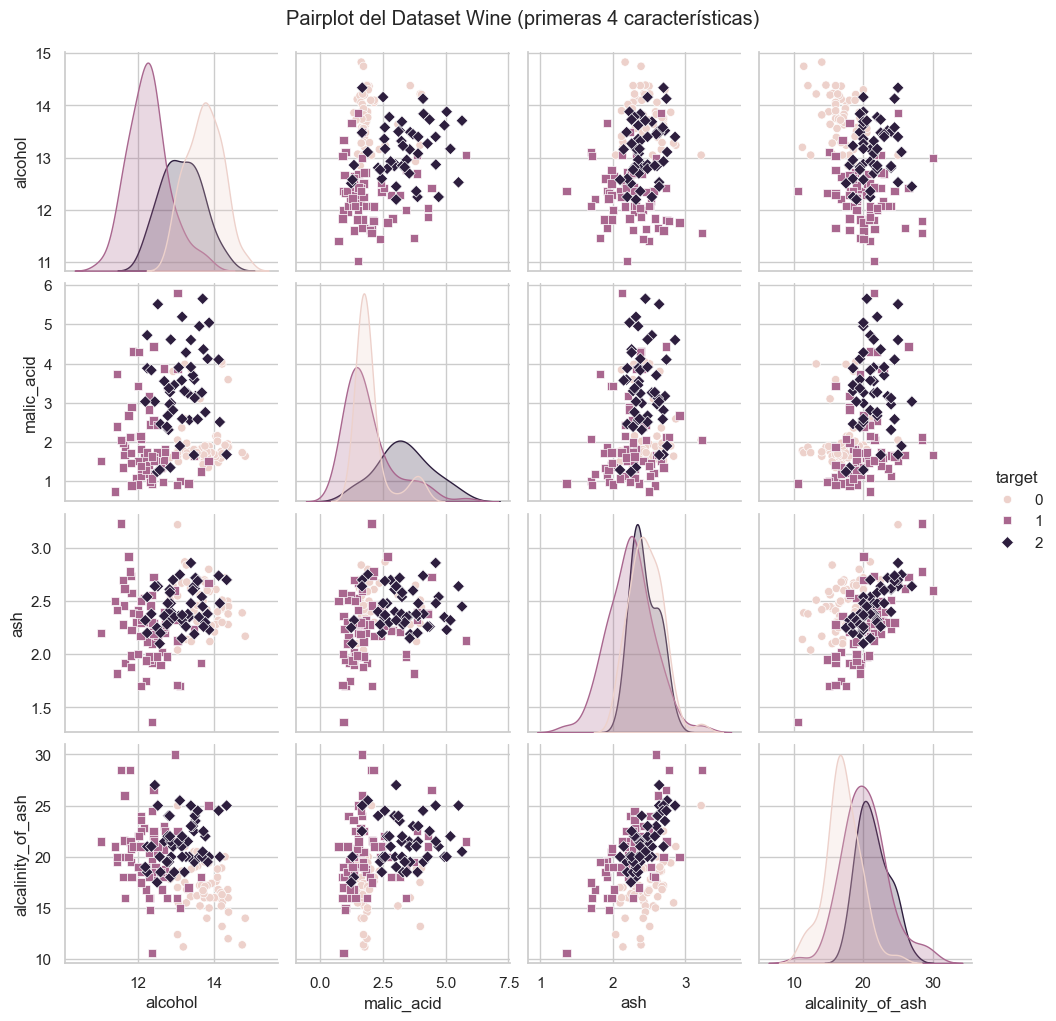

In [6]:
# 2. Gráfico de Dispersión (Pairplot)
# Para mantenerlo claro y rápido, visualizaremos solo 4 características.
print("\n--- Gráfico de Dispersión (Pairplot) - Wine ---")
subset_features = feature_names[:4]
sns.pairplot(df, hue='target', vars=subset_features, markers=["o", "s", "D"])
plt.suptitle("Pairplot del Dataset Wine (primeras 4 características)", y=1.02)
plt.show()

**¿Qué nos dice el gráfico?** Vemos que algunas características (como `alcohol` y `flavanoids`) ayudan a separar las clases de vino. Otras se mezclan más. Esto es normal. KNN es bueno manejando estas situaciones si escalamos bien los datos.

### División y Escalamiento de Datos

Este es un paso clave:
1.  **Dividir**: Separamos los datos en "entrenamiento" (para que el modelo aprenda) y "prueba" (para ver qué tan bien lo hace con datos nuevos).
2.  **Escalar**: Ajustamos los números de todas las características para que estén en una escala similar. Esto es vital para que KNN no le dé más importancia a una característica solo porque sus valores son más grandes.

In [7]:
# Dividir los datos en entrenamiento (train) y prueba (test)
# Usamos un 30% para prueba y una semilla aleatoria (random_state) para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaño de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de Prueba: {X_test.shape[0]} muestras")

# Escalamiento de Características
# kNN es sensible a la escala, por lo que estandarizamos los datos
scaler = StandardScaler()

# Ajustamos el scaler SOLO con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformamos los datos de prueba con el scaler ya ajustado
X_test_scaled = scaler.transform(X_test)

Tamaño de Entrenamiento: 124 muestras
Tamaño de Prueba: 54 muestras


In [8]:
# Mini demo: el efecto de k en una misma muestra
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

idx = 0  # probemos con la primera muestra de prueba
x0 = X_test[idx:idx+1]  # mantiene forma 2D
true_label = str(target_names[y_test[idx]]) if y_test[idx] < len(target_names) else str(y_test[idx])

for k_try in [1, 3, 5, 11]:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k_try, p=2, weights="uniform"))
    ])
    pipe.fit(X_train, y_train)

    # Predicción del ejemplo
    pred_code = int(pipe.predict(x0)[0])
    pred_name = str(target_names[pred_code]) if pred_code < len(target_names) else str(pred_code)

    # Vecinos y voto
    x0_scaled = pipe.named_steps["scaler"].transform(x0)
    distances, indices = pipe.named_steps["knn"].kneighbors(x0_scaled, n_neighbors=k_try)
    neighbor_labels = y_train[indices[0]]
    vote = Counter(neighbor_labels)
    vote_clean = {int(lbl): int(cnt) for lbl, cnt in sorted(vote.items())}

    print(f"k={k_try} -> pred: {pred_name} | real: {true_label}")
    print("  vecinos (label -> conteo):", vote_clean)
    print("  distancias primeras 3:", [float(f"{d:.3f}") for d in distances[0][:3]])
    print()

k=1 -> pred: class_0 | real: class_0
  vecinos (label -> conteo): {0: 1}
  distancias primeras 3: [2.029]

k=3 -> pred: class_0 | real: class_0
  vecinos (label -> conteo): {0: 3}
  distancias primeras 3: [2.029, 2.055, 2.214]

k=5 -> pred: class_0 | real: class_0
  vecinos (label -> conteo): {0: 5}
  distancias primeras 3: [2.029, 2.055, 2.214]

k=11 -> pred: class_0 | real: class_0
  vecinos (label -> conteo): {0: 11}
  distancias primeras 3: [2.029, 2.055, 2.214]



### 4.2 Feature Engineering (Selección de Variables)

En este tutorial usamos todas las características del vino. En un proyecto real, podríamos elegir solo las más importantes para simplificar el modelo y, a veces, mejorar su rendimiento. Por ahora, nos enfocamos en el proceso completo con todas las variables.

---

### Entrenamiento del Modelo kNN

Ahora, creamos el modelo. Le diremos que use 5 vecinos (`k=5`) para empezar. "Entrenar" en KNN es muy simple: solo consiste en que el modelo memorice los datos de entrenamiento.

In [9]:
# Elegimos un valor para 'k'
k = 5

# 1. Crear la instancia del clasificador
knn_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

# 2. Entrenar el modelo (en kNN, esto es solo almacenar los datos)
knn_model.fit(X_train_scaled, y_train)

print(f"Modelo kNN (k={k}) entrenado exitosamente.")

Modelo kNN (k=5) entrenado exitosamente.


### 4.3 Predicción (Función de ayuda)

Vamos a crear una función para predecir la clase de un nuevo vino. Esta función tomará las 13 características de un vino, las escalará (igual que hicimos con los datos de entrenamiento) y usará el modelo para adivinar a qué clase pertenece.

In [10]:
def predict_new_sample(pattern):
    """
    Recibe un patrón (vector de longitud n_features) y predice la clase.
    Depende de 'scaler' y 'knn_model' definidos globalmente.
    """
    try:
        pattern_np = np.asarray(pattern).reshape(1, -1)
        pattern_scaled = scaler.transform(pattern_np)
        prediction_code = knn_model.predict(pattern_scaled)
        probabilities = knn_model.predict_proba(pattern_scaled)[0]

        # Conversión a tipos nativos y redondeo para impresión limpia
        class_names = [str(c) for c in target_names]
        probs_list = [float(f"{p:.3f}") for p in probabilities]
        pairs = list(zip(class_names, probs_list))

        predicted_class_name = class_names[prediction_code[0]] if prediction_code[0] < len(class_names) else str(prediction_code[0])

        print("--- Predicción para el patrón ---")
        print(f"Clase predicha: {predicted_class_name} (código: {int(prediction_code[0])})")
        print("Probabilidades:")
        for name, p in pairs:
            print(f"  {name}: {p}")
        return predicted_class_name
    except Exception as e:
        print(f"Error durante la predicción: {e}")
        return None

# --- Ejemplos de uso (tomamos muestras reales del set de prueba) ---
new_sample_1 = X_test[0]
predict_new_sample(new_sample_1)

print("\n" + "="*30 + "\n")

new_sample_2 = X_test[1]
predict_new_sample(new_sample_2)

--- Predicción para el patrón ---
Clase predicha: class_0 (código: 0)
Probabilidades:
  class_0: 1.0
  class_1: 0.0
  class_2: 0.0


--- Predicción para el patrón ---
Clase predicha: class_1 (código: 1)
Probabilidades:
  class_0: 0.0
  class_1: 1.0
  class_2: 0.0


'class_1'

### 4.4 Evaluación del Modelo (Métricas)

Ahora vamos a medir qué tan bien funciona nuestro modelo. Usaremos los datos de "prueba", que el modelo no ha visto antes, para tener una idea honesta de su rendimiento.

In [11]:
# 1. Realizar predicciones sobre el conjunto de prueba
y_pred = knn_model.predict(X_test_scaled)

#### Accuracy (Precisión Global)

In [12]:
# 2. Calcular el Accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"--- Accuracy (Precisión Global) ---")
print(f"Accuracy: {accuracy * 100:.2f}%")

--- Accuracy (Precisión Global) ---
Accuracy: 94.44%


**¿Cómo interpretamos el accuracy?**
El accuracy mide el porcentaje total de aciertos en el conjunto de prueba. Un 100% significa que clasificamos correctamente todas las muestras. Valores ligeramente menores (p.ej., 95–98%) también pueden ser excelentes; la cifra exacta variará por la división train/test, el valor de k, la métrica de distancia y si usamos pesos por distancia.

---

#### Matriz de Confusión


--- Matriz de Confusión (k=5) ---
Filas: Valor Real / Columnas: Valor Predicho



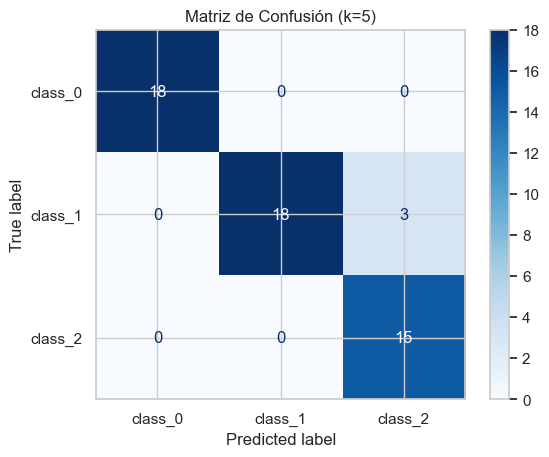

In [13]:
# 3. Calcular la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

print(f"\n--- Matriz de Confusión (k={k}) ---")
print("Filas: Valor Real / Columnas: Valor Predicho\n")

# Visualización gráfica de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Matriz de Confusión (k={k})")
plt.show()

**¿Cómo leer la Matriz de Confusión?**
Es un resumen visual de los aciertos y errores.
-   La **diagonal** (de arriba a la izquierda a abajo a la derecha) muestra los aciertos. Por ejemplo, cuántos vinos de la `class_0` se predijeron correctamente como `class_0`.
-   Los números **fuera de la diagonal** son los errores. Nos dicen qué clases se están confundiendo entre sí.

---

#### Reporte de Clasificación

(Métrica adicional muy útil)

In [14]:
# 4. Reporte de Clasificación (Precisión, Recall, F1-Score)
print(f"\n--- Reporte de Clasificación (k={k}) ---")
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)


--- Reporte de Clasificación (k=5) ---
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      0.86      0.92        21
     class_2       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      0.86      0.92        21
     class_2       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



**¿Cómo leemos el reporte? (Explicación sencilla)**

Este reporte nos da más detalles sobre el rendimiento para cada clase.

-   **Precision**: De todas las veces que el modelo dijo "esto es `class_0`", ¿cuántas veces acertó? Una alta precisión significa que el modelo es confiable cuando predice esa clase.
-   **Recall**: De todos los vinos que *realmente* eran `class_0`, ¿cuántos encontró el modelo? Un alto recall significa que el modelo no se "come" muchos ejemplos de esa clase.
-   **F1-Score**: Es un promedio entre Precision y Recall. Es útil para tener una sola métrica que resuma qué tan bien lo hace el modelo en una clase.
-   **Support**: Simplemente dice cuántos ejemplos reales de cada clase había en los datos de prueba.

## Visualización con PCA (2D)

Para datasets con muchas características, usar PCA para reducir a 2 dimensiones permite visualizar:
- La separabilidad entre clases
- Un clasificador KNN entrenado en el espacio PCA (solo con fines explicativos)


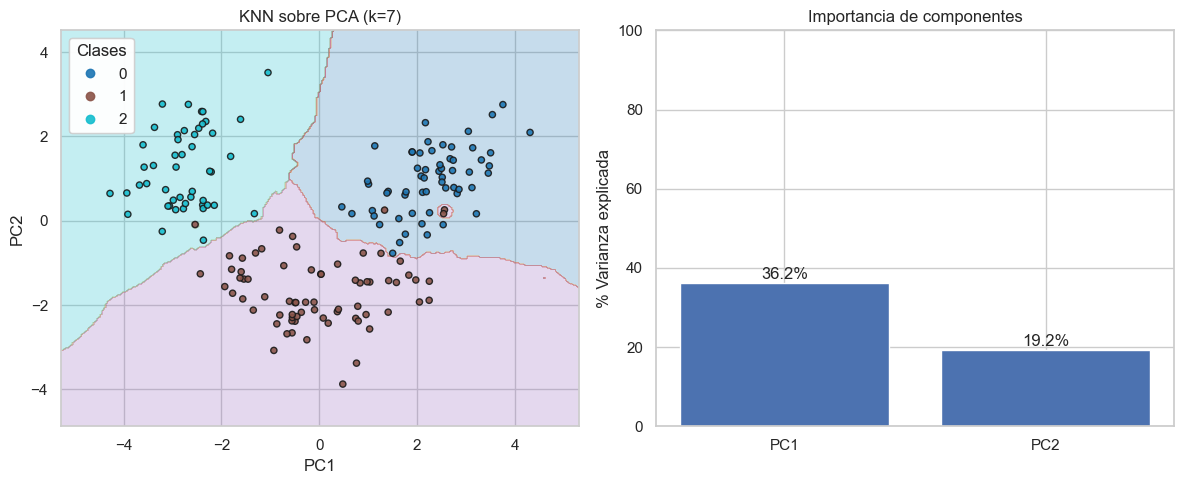

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

# Escalado + PCA a 2D
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Entrena KNN en el espacio PCA para visualización
k_vis = 7
knn_vis = KNeighborsClassifier(n_neighbors=k_vis, weights="distance", p=2)
knn_vis.fit(X_pca, y)

# Mapa de decisión (puede ser costoso si hay muchos puntos)
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Región de decisión + puntos
ax[0].contourf(xx, yy, Z, alpha=0.25, cmap="tab10")
scatter = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap="tab10", edgecolors="k", alpha=0.9)
ax[0].set_title(f"KNN sobre PCA (k={k_vis})")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
legend1 = ax[0].legend(*scatter.legend_elements(), title="Clases")
ax[0].add_artist(legend1)

# Varianza explicada
exp_var = pca.explained_variance_ratio_
ax[1].bar(["PC1", "PC2"], exp_var * 100)
ax[1].set_ylabel("% Varianza explicada")
ax[1].set_ylim(0, 100)
ax[1].set_title("Importancia de componentes")
for i, v in enumerate(exp_var * 100):
    ax[1].text(i, v + 1, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()


## Notas y buenas prácticas

- Escalemos siempre antes de KNN (usa Pipeline si es posible).
- Probemos varios k (en binario, valores impares evitan empates).
- Comparemos p=1 vs p=2 y `weights=uniform` vs `distance`.
- Si una clase sale peor, revisemos métricas por clase y la matriz de confusión.
- Si hay muchas variables, usemos PCA o selección de características.
- KNN puede ser lento al predecir con muchos datos (usa menos features o muestrea si es grande).


## Referencias

1. Scikit-learn (Documentación Oficial)
   - Vecinos: https://scikit-learn.org/stable/modules/neighbors.html
   - KNeighborsClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
   - Datasets (Wine): https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html
2.  **OpenAI. (2024).** *ChatGPT.* (Modelo de lenguaje grande). Consultado el 4/11/2025, de [https://chat.openai.com/](https://chat.openai.com/)
